# Imports & Load Data 🏜️

In [ ]:
!pip install -q -U ultralytics roboflow ipywidgets wandb

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
import cv2
import matplotlib.pyplot as plt
import random
from typing import List, Tuple

### Load Dataset

In [ ]:
from kaggle_secrets import UserSecretsClient
roboflow_api = UserSecretsClient().get_secret('ROBOFLOW')
wandb_api_key = UserSecretsClient().get_secret('WANDB')

In [ ]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api)
project = rf.workspace("potholedetection-86cjl").project("pothole_segmentation")
version = project.version(8)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.79, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to pothole_segmentation-8 in yolov8:: 100%|██████████| 6160/6160 [00:01<00:00, 5388.00it/s]


### Visualize Dataset

In [ ]:
def overlay_mask_on_img(img: np.ndarray, mask:np.ndarray, color=(255, 0, 0))->np.ndarray:
    overlay = img.copy().astype(int)
    color = np.array(color).astype(int)
    overlay[mask == 1] += color
    return overlay

def load_mask_vertices(mask_path: str, img_height:int, img_width: int)->List[dict]:
    with open(mask_path, 'r') as file:
        lines = file.readlines()
    polygon_labels = []
    for line in lines:
        values = line.strip().split(' ')
        class_label = int(values[0])
        polygon_coords = [(int(float(values[i]) * img_width), int(float(values[i + 1]) * img_height)) for i in range(1, len(values), 2)]
        polygon_labels.append({'class_label': 1, 'polygon_coords': polygon_coords})

    return polygon_labels

def generate_mask_from_vertices(vertices: List[dict], img_height:int, img_width: int)->np.ndarray:
    binary_mask = np.zeros((img_height,img_width), dtype=np.uint8)
    for polygon in vertices :
        polygon_coords = np.array(polygon['polygon_coords'],np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(binary_mask,[polygon_coords],color=(1))
    return binary_mask

def load_mask(mask_path: str, img_height:int, img_width: int)->np.ndarray:
    vertices = load_mask_vertices(mask_path, img_height, img_width)
    mask = generate_mask_from_vertices(vertices, img_height, img_width)
    return mask

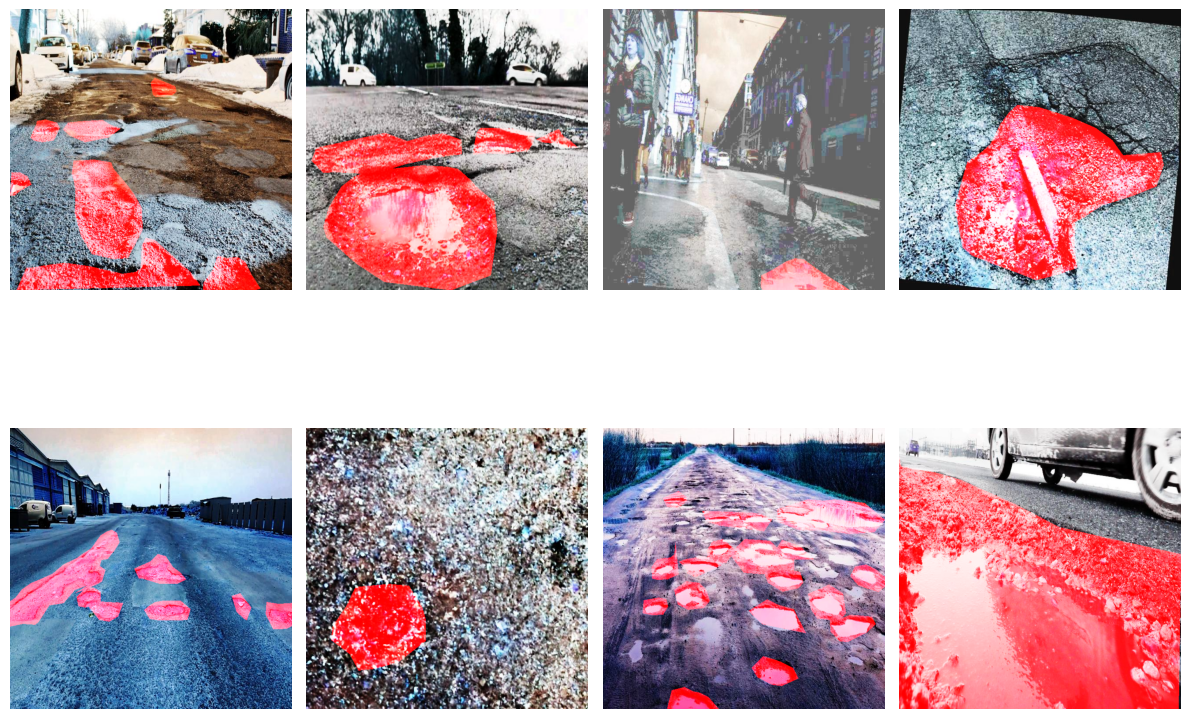

In [ ]:
def visualize_segmentation_masks_from_directory(data_dir, nrows = 2, ncols = 4):
    img_dir, mask_dir = os.path.join(data_dir, 'images'), os.path.join(data_dir, 'labels')
    img_paths = os.listdir(img_dir)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 5*nrows))
    for i in range(nrows*ncols):
        img_name = img_paths[random.randint(0, len(img_paths)-1)]
        mask_name = '.'.join(img_name.split('.')[:-1])+'.txt'
        img = cv2.imread(os.path.join(img_dir, img_name))
        mask = load_mask(os.path.join(mask_dir, mask_name), img.shape[0], img.shape[1])
        img = overlay_mask_on_img(img, mask)
        ax.flatten()[i].imshow(img)
        ax.flatten()[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_segmentation_masks_from_directory(r"/kaggle/working/pothole_segmentation-8/valid")

### Preparing Data & YAML file

In [ ]:
TRAIN_PATH = r"/kaggle/working/pothole_segmentation-8/train"
VAL_PATH   = r"/kaggle/working/pothole_segmentation-8/valid"
TEST_PATH  = r"/kaggle/working/pothole_segmentation-8/test"
YAML_PATH = r"/kaggle/working/pothole_segmentation-8/data.yaml"

yaml_content = f'''
names:
- pothole
nc: 1
roboflow:
  license: Public Domain
  project: pothole_segmentation
  url: https://universe.roboflow.com/potholedetection-86cjl/pothole_segmentation/dataset/8
  version: 8
  workspace: potholedetection-86cjl
test: {TEST_PATH}
train: {TRAIN_PATH}
val: {VAL_PATH}
'''

with open(YAML_PATH, 'w') as file:
    file.write(yaml_content)

# Train Yolov8 Segmentation 🧨

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

100%|██████████| 6.74M/6.74M [00:00<00:00, 110MB/s]


In [ ]:
import torch
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available")

Number of GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4


In [ ]:
results = model.train(data=YAML_PATH, epochs=10, imgsz=640, device=[0, 1])

Ultralytics YOLOv8.2.79 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/kaggle/working/pothole_segmentation-8/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

100%|██████████| 755k/755k [00:00<00:00, 20.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Currently logged in as: silverelf144. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240819_122734-x6i39vy4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/silverelf144/YOLOv8
wandb: 🚀 View run at https://wandb.ai/silverelf144/YOLOv8/runs/x6i39vy4


Overriding model.yaml nc=80 with nc=1
Transferred 381/417 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 113MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/pothole_segmentation-8/train/labels... 2443 images, 12 backgrounds, 0 corrupt: 100%|██████████| 2443/2443 [00:02<00:00, 971.67it/s]


train: New cache created: /kaggle/working/pothole_segmentation-8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/pothole_segmentation-8/valid/labels... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<00:00, 1105.59it/s]


val: New cache created: /kaggle/working/pothole_segmentation-8/valid/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.67G      1.718      3.432      2.846       1.76         12        640: 100%|██████████| 153/153 [00:35<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


                   all        317        727      0.591      0.472      0.516      0.265      0.587      0.464      0.493      0.238

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.63G      1.637      2.886      2.231      1.676         12        640: 100%|██████████| 153/153 [00:29<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


                   all        317        727      0.545        0.4      0.425      0.204      0.559      0.403      0.423      0.198

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.54G      1.598      2.741      1.982      1.627         11        640: 100%|██████████| 153/153 [00:29<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]


                   all        317        727      0.673      0.503      0.551      0.257      0.689      0.503      0.556      0.256

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.57G      1.593      2.721      1.833      1.645         15        640: 100%|██████████| 153/153 [00:29<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


                   all        317        727      0.621      0.556      0.604       0.32      0.621      0.556      0.596      0.283

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10       1.7G       1.53      2.695      1.663      1.594         14        640: 100%|██████████| 153/153 [00:28<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


                   all        317        727      0.715      0.582      0.659      0.371      0.706      0.575      0.642      0.332

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.63G      1.504       2.59      1.524      1.571          9        640: 100%|██████████| 153/153 [00:29<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


                   all        317        727      0.698      0.571      0.648      0.336       0.68      0.561      0.635      0.319

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.68G      1.465      2.477      1.445       1.51         12        640: 100%|██████████| 153/153 [00:28<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


                   all        317        727      0.695      0.664      0.715       0.41      0.697      0.652      0.704      0.376

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.63G      1.443      2.435      1.388       1.49         10        640: 100%|██████████| 153/153 [00:28<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


                   all        317        727      0.771      0.629      0.732      0.412      0.779      0.635      0.732      0.386

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.68G      1.395      2.371      1.312      1.472         10        640: 100%|██████████| 153/153 [00:28<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.58it/s]


                   all        317        727      0.765      0.666      0.748      0.432      0.769      0.673      0.745      0.406

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.63G      1.365      2.304      1.203      1.451          8        640: 100%|██████████| 153/153 [00:28<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


                   all        317        727      0.774      0.673      0.761      0.449      0.777      0.675      0.751      0.418

10 epochs completed in 0.098 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.79 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


                   all        317        727      0.773      0.675      0.761       0.45      0.778      0.671       0.75      0.417
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆█▇▆▅▄▃▂▁
wandb:                  lr/pg1 ▃▆█▇▆▅▄▃▂▁
wandb:                  lr/pg2 ▃▆█▇▆▅▄▃▂▁
wandb:        metrics/mAP50(B) ▃▁▄▅▆▆▇▇██
wandb:        metrics/mAP50(M) ▂▁▄▅▆▆▇███
wandb:     metrics/mAP50-95(B) ▃▁▃▄▆▅▇▇▇█
wandb:     metrics/mAP50-95(M) ▂▁▃▄▅▅▇▇██
wandb:    metrics/precision(B) ▂▁▅▃▆▆▆███
wandb:    metrics/precision(M) ▂▁▅▃▆▅▅███
wandb:       metrics/recall(B) ▃▁▄▅▆▅█▇██
wandb:       metrics/recall(M) ▃▁▄▅▅▅▇▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▆▆▄▄▃▃▂▁
wandb:          train/cls_loss █▅▄▄▃▂▂▂▁▁
wandb:          train/dfl_loss █▆▅▅▄▄▂▂▁▁
wandb:          train/seg_loss █▅▄▄▃▃▂▂▁▁
wandb:            val/box_loss ▅██▆▄▄▃▃▂▁
wandb:            val/cls_loss ██▅▄▃▃▂▂▁▁
wandb:            val/dfl_loss ▅█▇▄▃▄▂▂▂▁
wandb:            val/seg_loss

# Inference & Benchmarking 🕵️

### Inference Pipeline

In [ ]:
model = YOLO("/kaggle/working/runs/segment/train/weights/best.pt")

In [ ]:
def inference_pipeline(model, img: np.ndarray|str, threshold = 0)->np.ndarray:
    res = model(img)
    masks = [np.sum(pred.masks.data.cpu().numpy(), axis=0) for pred in res]
    return masks


0: 640x640 1 pothole, 17.8ms
Speed: 4.0ms preprocess, 17.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pothole, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 potholes, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 potholes, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pothole, 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


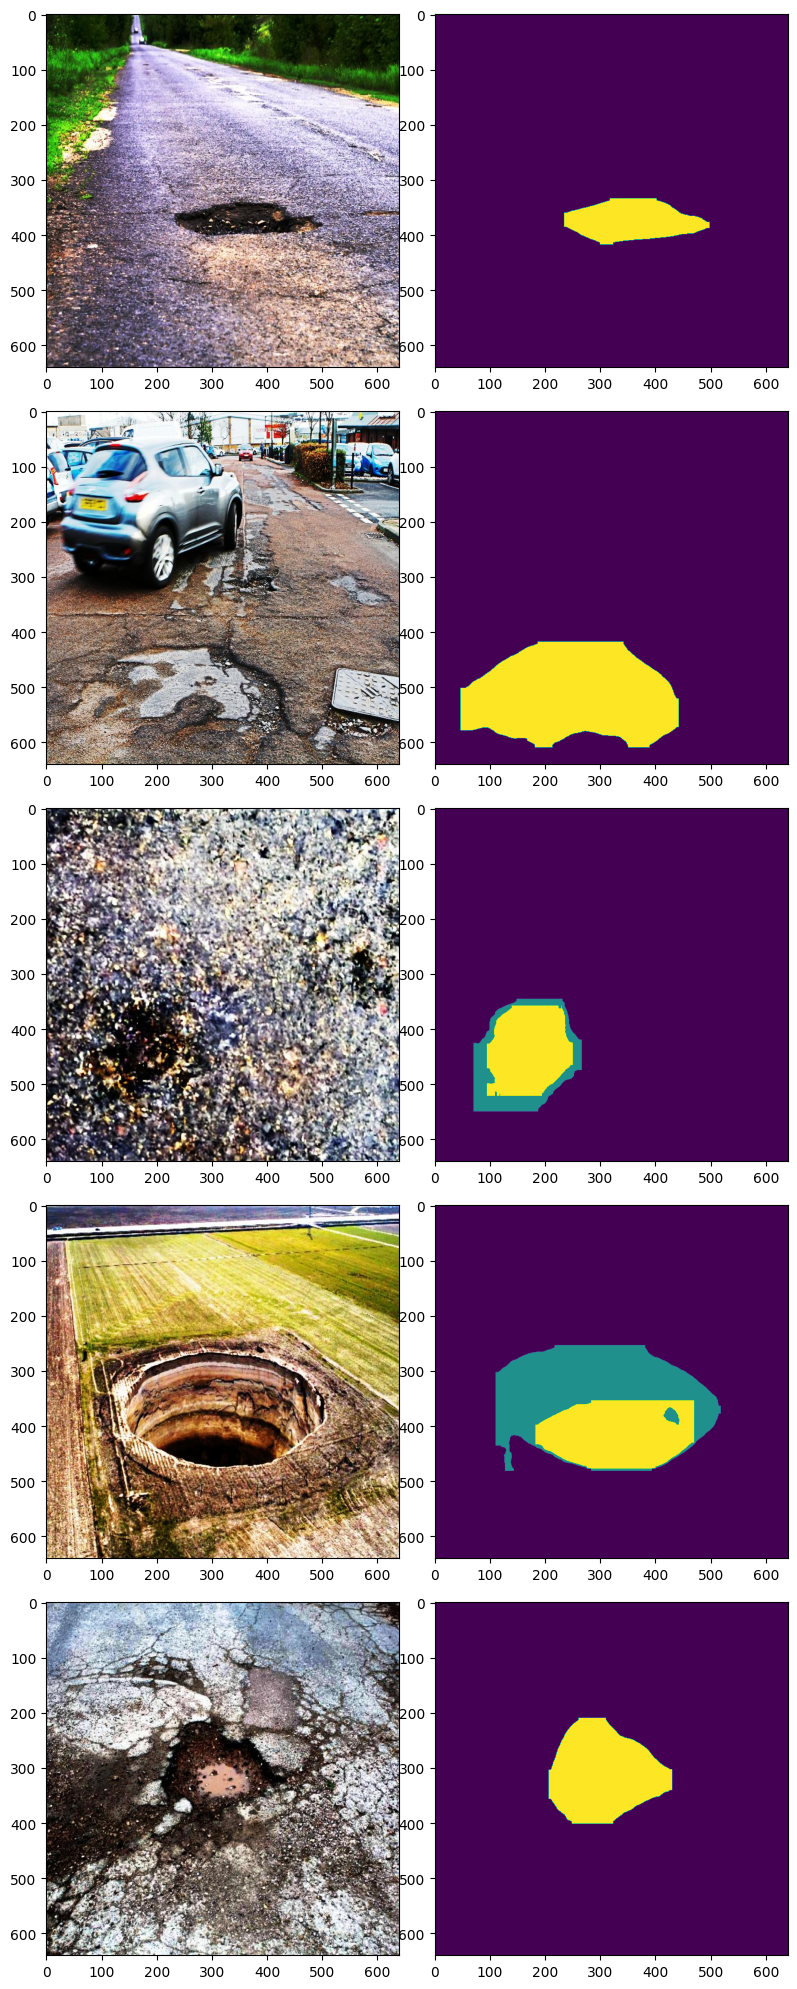

In [ ]:
def visualize_data(model, data_dir: str, m: int = 5)->None:
    img_dir, mask_dir = os.path.join(data_dir, 'images'), os.path.join(data_dir, 'labels')
    img_paths = os.listdir(img_dir)
    n = len(img_paths)
    fig, ax = plt.subplots(nrows=m, ncols=2, figsize=(8, 4*m))
    for i in range(m):
        idx = random.randint(0, n-1)
        img = cv2.imread(os.path.join(img_dir, img_paths[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, 0].imshow(img)
        pred = inference_pipeline(model, img)
        ax[i, 1].imshow(pred[0])
    plt.tight_layout()
    plt.show()

visualize_data(model, VAL_PATH)

### Benchmarks

In [ ]:
yaml_content = f'''
names:
- pothole
nc: 1
roboflow:
  license: Public Domain
  project: pothole_segmentation
  url: https://universe.roboflow.com/potholedetection-86cjl/pothole_segmentation/dataset/8
  version: 8
  workspace: potholedetection-86cjl
test: {TEST_PATH}
train: {TRAIN_PATH}
val: {TEST_PATH}
'''

with open(YAML_PATH, 'w') as file:
    file.write(yaml_content)

In [ ]:
metrics = model.val(data=YAML_PATH)
metrics.results_dict

Ultralytics YOLOv8.2.79 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /kaggle/working/pothole_segmentation-8/test/labels... 314 images, 1 backgrounds, 0 corrupt: 100%|██████████| 314/314 [00:00<00:00, 1053.36it/s]


val: New cache created: /kaggle/working/pothole_segmentation-8/test/labels.cache


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


                   all        314        639      0.825      0.637      0.763      0.431      0.833      0.638      0.758      0.397
Speed: 0.3ms preprocess, 7.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train2


{'metrics/precision(B)': 0.8247635357423274,
 'metrics/recall(B)': 0.6369327073552425,
 'metrics/mAP50(B)': 0.7628805984495372,
 'metrics/mAP50-95(B)': 0.4313726386647172,
 'metrics/precision(M)': 0.8331378740668818,
 'metrics/recall(M)': 0.6384976525821596,
 'metrics/mAP50(M)': 0.7584728667982451,
 'metrics/mAP50-95(M)': 0.3970978556096853,
 'fitness': 0.8977587913717405}

### Real-World Images


0: 448x640 1 pothole, 15.5ms
Speed: 3.4ms preprocess, 15.5ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)


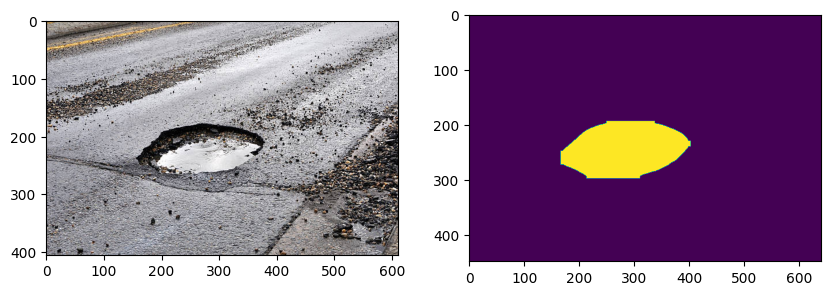

In [ ]:
img = cv2.imread(r"/kaggle/input/pothole-img/pothole.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = inference_pipeline(model, img)[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax.flatten()[0].imshow(img)
ax.flatten()[1].imshow(mask)